In [160]:
import torch
from matplotlib import pyplot as plt

In [165]:
image = plt.imread('monkey.jpeg')[:, :, 0]

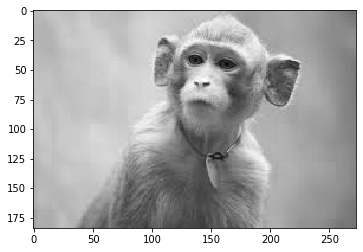

In [168]:
plt.imshow(image, cmap='gray')

In [277]:
model_resnet_3 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
model_resnet_1 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)

Using cache found in /Users/julian/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /Users/julian/.cache/torch/hub/pytorch_vision_v0.6.0


In [285]:
torch.save(model_resnet_3, 'resnet_18_pretrained.pth')

In [173]:
# Change input layer
model_resnet_1.conv1.weight.data = model_resnet_3.conv1.weight.data.sum(axis=1).reshape(64, 1, 7, 7)
model_resnet_1.conv1.in_channels = 1

In [174]:
print(sum([param.nelement() for param in model_resnet_1.parameters()])/sum([param.nelement() for param in model_resnet_3.parameters()]))

0.9994634506555963


In [189]:
# Defino entradas
input_image_1 = torch.from_numpy(image.reshape(1, *image.shape).copy()).float()
input_image_3 = torch.cat([input_image_1, input_image_1, input_image_1])
input_image_1 = input_image_1.reshape(-1, *input_image_1.shape)
input_image_3 = input_image_3.reshape(-1, *input_image_3.shape)
print(input_image_1.shape, input_image_3.shape)

torch.Size([1, 1, 184, 273]) torch.Size([1, 3, 184, 273])


In [193]:
y_1 = model_resnet_1(input_image_1)
y_3 = model_resnet_3(input_image_3)
torch.abs(y_1).sum(), torch.abs(y_3).sum()

(tensor(710.8860, grad_fn=<SumBackward0>),
 tensor(710.8861, grad_fn=<SumBackward0>))

In [194]:
# Test batch normalization
bn_out = torch.nn.BatchNorm2d(1)(input_image_1)
bn_out.std(), bn_out.mean()

(tensor(1.0000, grad_fn=<StdBackward0>),
 tensor(-8.9564e-08, grad_fn=<MeanBackward0>))

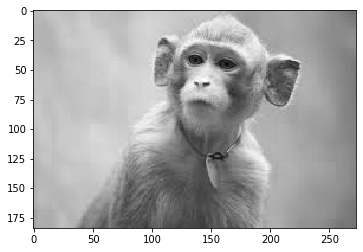

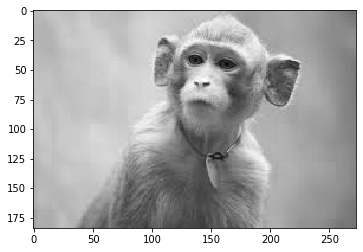

In [196]:
plt.imshow(input_image_1.reshape(*image.shape).numpy(), cmap='gray')
plt.show()
plt.imshow(bn_out.detach().reshape(*image.shape).numpy(), cmap='gray')

In [231]:
SAMPLE_RATE = 22050
duartion = 5

In [203]:
from birds_utils import mel_spectrogram_pytorch, get_bin_audio

In [233]:
audio_1 = get_bin_audio('./dataset/bin_22050_librosa/aldfly/XC134874.mp3.bin')[:SAMPLE_RATE*duartion]
audio_1 = audio_1.reshape(1, 1, SAMPLE_RATE*duartion )
audio_2 = get_bin_audio('./dataset/bin_22050_librosa/aldfly/XC135454.mp3.bin')[:SAMPLE_RATE*duartion]
audio_2 = audio_2.reshape(1, 1, SAMPLE_RATE*duartion )

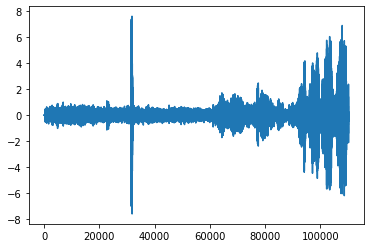

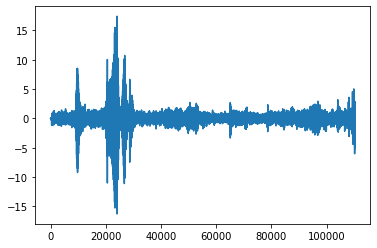

In [234]:
plt.plot(audio_1.squeeze())
plt.show()
plt.plot(audio_2.squeeze())

In [236]:
import numpy as np
audio_batch = np.vstack([audio_1, audio_2])
audio_batch.shape

(2, 1, 110250)

In [237]:
mel_net = mel_spectrogram_pytorch(
    window_size=2048,
    init_fourier=True,
    train_fourier=False,
    init_mel=True,
    train_mel=False,
    sr=22050,
    n_mels=128
)

In [251]:
mel_spectrogram = mel_net(torch.from_numpy(audio_batch).float())
mel_spectrogram = mel_spectrogram.reshape(-1, 1, *mel_spectrogram.shape[1:])
normalized_mel_spectrogram = torch.nn.BatchNorm2d(1)(mel_spectrogram)

In [252]:
mel_spectrogram.shape

torch.Size([2, 1, 128, 423])

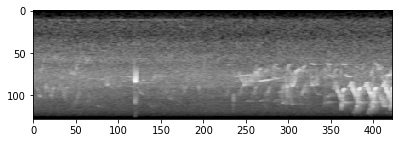

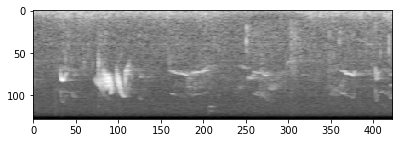

In [256]:
plt.figure(figsize=(30, 2))
plt.imshow(normalized_mel_spectrogram[0].detach().squeeze().numpy(), cmap='gray')

plt.figure(figsize=(30, 2))
plt.imshow(normalized_mel_spectrogram[1].detach().squeeze().numpy(), cmap='gray')


In [263]:
normalized_mel_spectrogram.mean(), normalized_mel_spectrogram.std()

(tensor(1.1810e-07, grad_fn=<MeanBackward0>),
 tensor(0.9998, grad_fn=<StdBackward0>))

In [328]:
model_resnet_3.conv1.weight.data.shape

torch.Size([64, 3, 7, 7])

In [316]:
def resnet_BW(resnet18):
    resnet18.conv1.in_channels = 1
    resnet18.conv1.weight.data = resnet18.conv1.weight.data.sum(axis=1).reshape(64, 1, 7, 7)
    return resnet18

In [292]:
resnet18bw = resnet_BW()

In [293]:
resnet18bw(normalized_mel_spectrogram)

tensor([[-1.1109, -0.0416, -0.9486,  ..., -0.6106,  1.5905,  1.0321],
        [-0.0213, -0.7713, -0.2384,  ..., -0.5012,  1.0391,  1.1636]],
       grad_fn=<AddmmBackward>)

In [310]:
resnet_type='resnet18'
pretrained = True
model_resnet = torch.hub.load('pytorch/vision:v0.6.0', resnet_type, pretrained=pretrained)

Using cache found in /Users/julian/.cache/torch/hub/pytorch_vision_v0.6.0


In [330]:
class BirdsNet(torch.nn.Module):
    def __init__(self, window_size=2048, n_mels=128, sr=22050, pretrained=True, n_classes=264, resnet_type='resnet18', init_fourier=True, init_mel=True, train_fourier=False, train_mel=False, amin=1e-10, top_db=80.0):
        super(BirdsNet, self).__init__()
        if resnet_type=='resnet18':
            linear_inp = 512
        else:
            linear_inp = 2048
        self.mel_spectrogram = mel_spectrogram_pytorch(
            window_size=window_size,
            init_fourier=init_fourier,
            init_mel=init_mel,
            train_fourier=train_fourier,
            train_mel=train_mel,
            sr=sr,
            n_mels=n_mels,
            amin=amin,
            top_db=top_db
        )
        self.bn1 = torch.nn.BatchNorm2d(1)
        model_resnet = torch.hub.load('pytorch/vision:v0.6.0', resnet_type, pretrained=pretrained)
        model_resnet_BW = resnet_BW(model_resnet)
        self.resnet = torch.nn.Sequential(*list(model_resnet_BW.children())[:-1])
        self.conv_out = torch.nn.Conv2d(linear_inp, n_classes, 1)
    
    def forward(self, x):
        mel_spectrogram = self.mel_spectrogram(x)
        mel_spectrogram = mel_spectrogram.reshape(-1, 1, *mel_spectrogram.shape[1:])
        mel_spectrogram_normalized = self.bn1(mel_spectrogram)
        x = self.resnet(mel_spectrogram_normalized)
        x = self.conv_out(x).flatten(start_dim=1)
        return mel_spectrogram_normalized, x

In [331]:
model = BirdsNet()

Using cache found in /Users/julian/.cache/torch/hub/pytorch_vision_v0.6.0


In [323]:
mel_spectrogram_normalized, y_pred = model(torch.from_numpy(audio_batch).float())

In [324]:
mel_spectrogram_normalized.shape, y_pred.shape

(torch.Size([2, 1, 128, 423]), torch.Size([2, 264]))

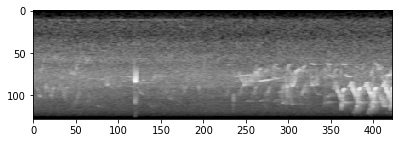

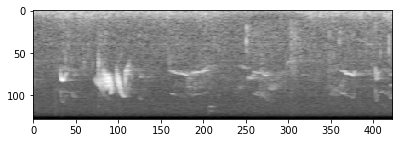

In [322]:
plt.figure(figsize=(30, 2))
plt.imshow(normalized_mel_spectrogram[0, 0].detach().squeeze().numpy(), cmap='gray')

plt.figure(figsize=(30, 2))
plt.imshow(normalized_mel_spectrogram[1, 0].detach().squeeze().numpy(), cmap='gray')
